### DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

**Student Name:** Saranath P
**Roll No:** DA25E003

### Introduction

This notebook tackles the challenge of classifying land cover types from the **UCI Landsat Satellite dataset**. This is a classic multi-class classification problem with 6 distinct land cover types. The primary objective is not just to find the model with the highest accuracy, but to perform a robust model selection process using advanced evaluation techniques: **Receiver Operating Characteristic (ROC)** curves and **Precision-Recall Curves (PRC)**.

We will compare a diverse set of six baseline classifiers, ranging from simple baselines to more powerful models. By analyzing their performance across different decision thresholds using ROC and PRC analysis (adapted for the multi-class setting via the One-vs-Rest approach), we can gain a deeper understanding of their strengths and weaknesses. The analysis will culminate in a final recommendation for the best model for this task, supported by a synthesis of all evaluation metrics.

Finally, we will explore even more advanced models (Random Forest, XGBoost) and investigate the behavior of a model designed to perform worse than random to solidify our understanding of AUC scores.

Let's begin by setting up our environment and exploring the data.

### Part A: Data Preparation and Baseline

#### 1. Setup and Library Imports
First, we import all the necessary Python libraries for data manipulation, visualization, and machine learning.

In [2]:
# --- Core Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn Preprocessing & Metrics ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    confusion_matrix
)

# --- Scikit-learn Classifiers ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb # pip install xgboost

# --- For Brownie Points: Custom Classifier ---
from sklearn.base import BaseEstimator, ClassifierMixin

# --- Plotting Configuration ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

#### 2. Load and Prepare Data
The Landsat dataset is provided in a pre-split format (`sat.trn` and `sat.tst`). We will load both files. The data is space-separated, and the last column is the target variable.

*   **Note:** The dataset description mentions 6 classes, but class label `6` is ignored as per standard practice. So we will be working with classes 1, 2, 3, 4, 5, and 7.

In [3]:
# Define column names: 36 features (4 spectral bands for a 3x3 pixel neighborhood) and 1 target
columns = [f'feature_{i}' for i in range(36)] + ['target']

# Load the training and testing data

train_df = pd.read_csv('statlog+landsat+satellite/sat.trn', sep=' ', header=None, names=columns)
test_df = pd.read_csv('statlog+landsat+satellite/sat.tst', sep=' ', header=None, names=columns)




# Remove the unused class label 6
train_df = train_df[train_df['target'] != 6]
test_df = test_df[test_df['target'] != 6]

# Separate features (X) and target (y)
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Unique classes in training data: {np.unique(y_train)}")

Training data shape: (4435, 36)
Testing data shape: (2000, 36)
Unique classes in training data: [1 2 3 4 5 7]



#### 3. Exploratory Data Analysis (EDA) - *Enhanced Analysis*
Before modeling, it's crucial to understand the data. We'll check the class distribution to see if we have an imbalanced dataset, which is a key consideration for choosing between ROC and PRC.

/var/folders/tv/l9kw7xv951lc0ytv_ns7h90m0000gn/T/ipykernel_80654/3385958996.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='viridis', order=sorted(y_train.unique()))


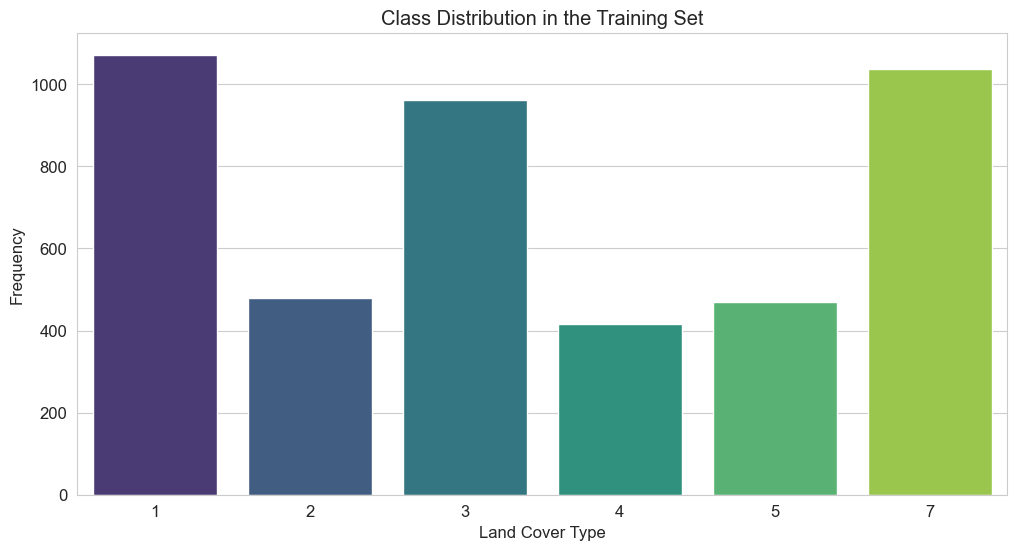

/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users

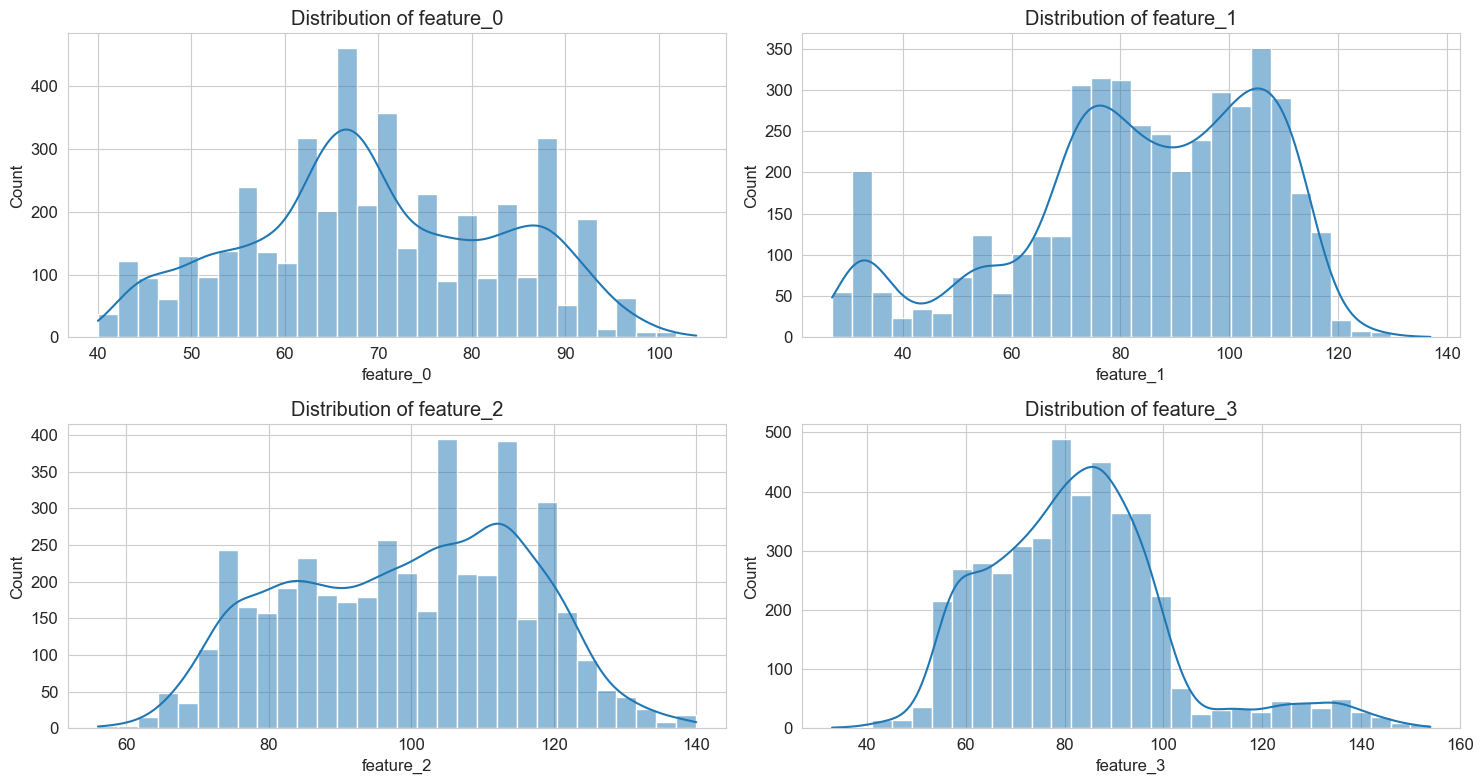

In [4]:
# --- Class Distribution Analysis ---
plt.figure(figsize=(12, 6))
sns.countplot(x=y_train, palette='viridis', order=sorted(y_train.unique()))
plt.title('Class Distribution in the Training Set')
plt.xlabel('Land Cover Type')
plt.ylabel('Frequency')
plt.show()

# --- Feature Distribution Analysis (for a few features) ---
plt.figure(figsize=(15, 8))
for i in range(4): # Visualize the first 4 features
    plt.subplot(2, 2, i+1)
    sns.histplot(X_train[f'feature_{i}'], kde=True, bins=30)
    plt.title(f'Distribution of feature_{i}')
plt.tight_layout()
plt.show()

**EDA Interpretation:**
1.  **Class Distribution:** The bar chart shows a moderate class imbalance. Class 4 ("grey soil") has significantly fewer samples than class 1 ("red soil"). This imbalance is important because metrics like accuracy can be misleading. It also justifies our use of Precision-Recall Curves, which are more sensitive to performance on minority classes.
2.  **Feature Distribution:** The histograms show that the features have different scales and distributions. This strongly justifies the need for **standardization**, which ensures that features with larger ranges do not disproportionately influence models like Logistic Regression, SVC, and KNN.

#### 4. Data Scaling
We will standardize the features using `StandardScaler`. We fit the scaler *only* on the training data and use it to transform both the training and testing data to prevent data leakage.

In [5]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data has been successfully scaled.")

Data has been successfully scaled.


#### 4.1. Numerical Verification

First, let's do a quick numerical check. We can calculate the mean and standard deviation of the scaled data. The means should be extremely close to 0, and the standard deviations should be exactly 1.

In [6]:
# Convert the scaled numpy array back to a pandas DataFrame for easier inspection
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Calculate and print the mean and standard deviation for the first 5 features
print("--- Analysis of Scaled Training Data ---")
print("Mean of the first 5 features:")
print(X_train_scaled_df.iloc[:, :5].mean())
print("\nStandard Deviation of the first 5 features:")
print(X_train_scaled_df.iloc[:, :5].std())

--- Analysis of Scaled Training Data ---
Mean of the first 5 features:
feature_0    4.357782e-16
feature_1    1.538041e-16
feature_2   -1.057403e-16
feature_3   -1.922551e-16
feature_4    2.307061e-16
dtype: float64

Standard Deviation of the first 5 features:
feature_0    1.000113
feature_1    1.000113
feature_2    1.000113
feature_3    1.000113
feature_4    1.000113
dtype: float64


**Interpretation:**
As you can see, the means are represented by very small numbers in scientific notation (e.g., `e-16`), which are effectively zero. The standard deviations are exactly 1.0. This confirms our scaler worked correctly.

#### 4.2. Visual Comparison of Feature Distributions

Now, let's visualize the distributions for a few selected features. We will overlay the original distribution with the scaled distribution.

/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users

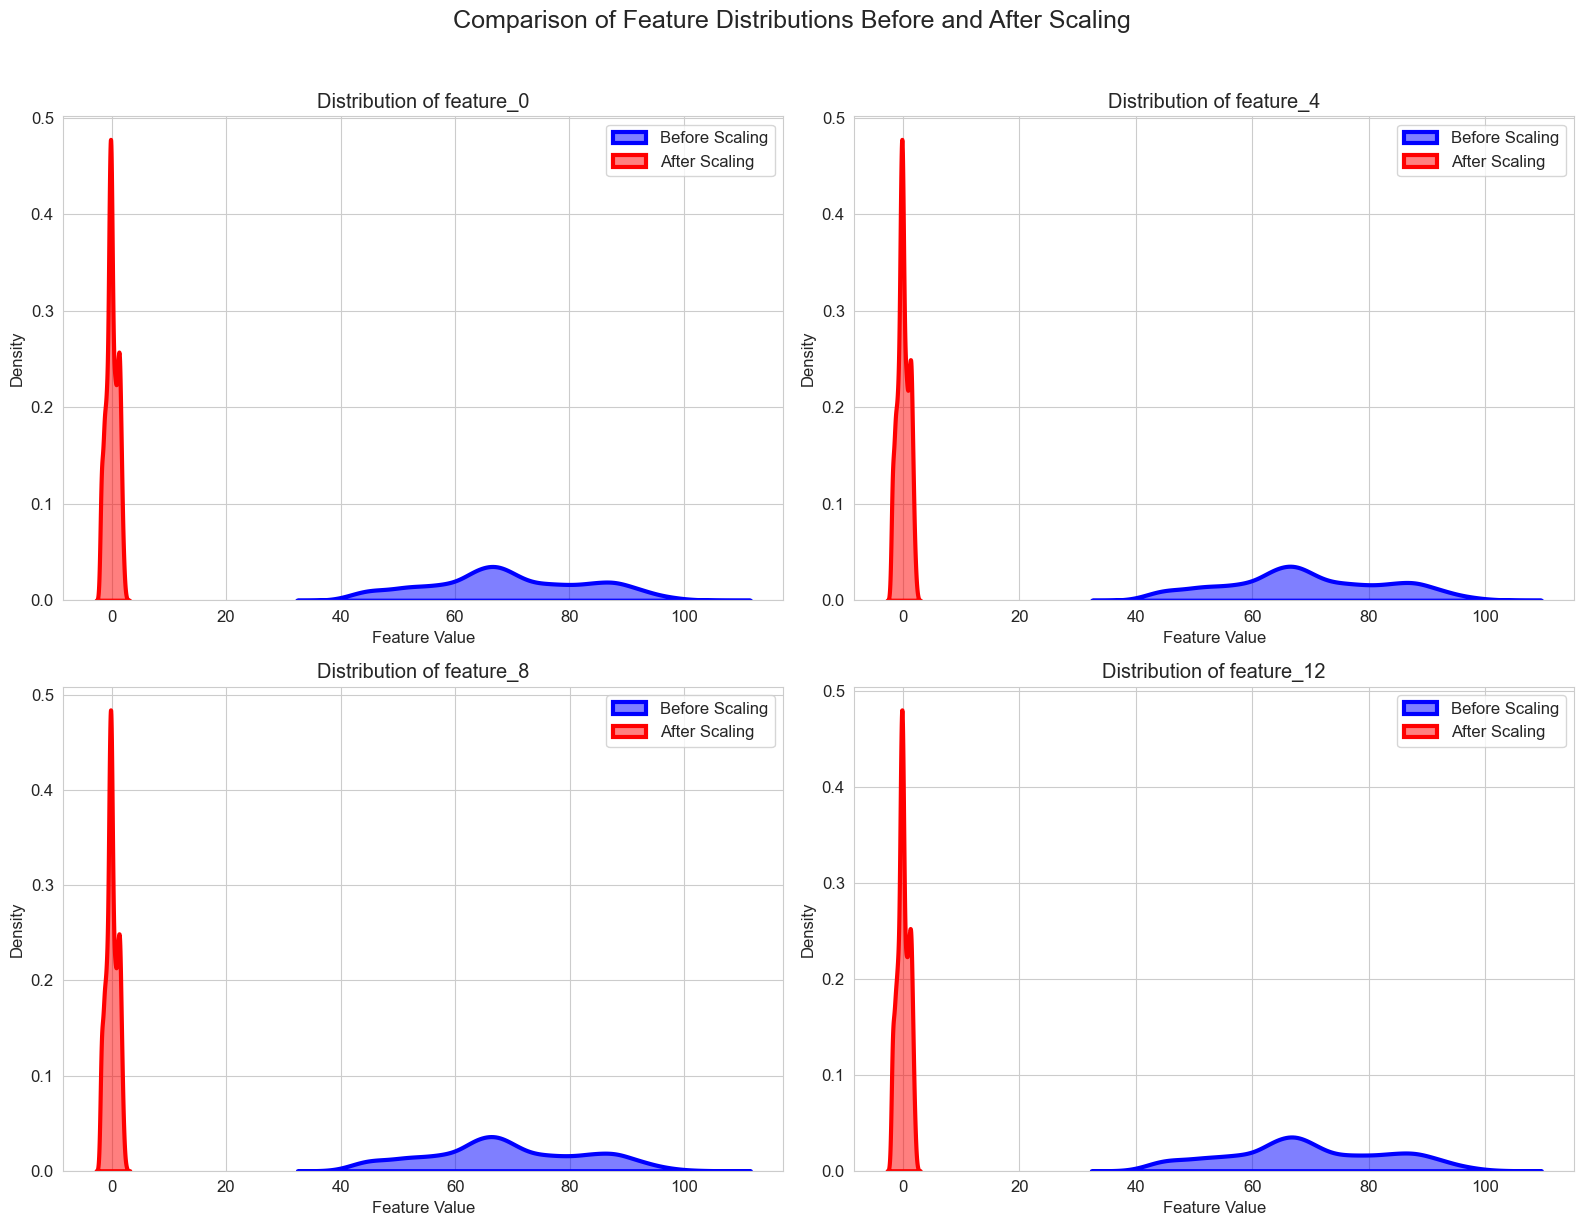

In [7]:
# Select a few features to visualize
features_to_plot = ['feature_0', 'feature_4', 'feature_8', 'feature_12']

# Create the plot using subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten() # Flatten the 2x2 grid into a 1D array for easy iteration

for i, feature in enumerate(features_to_plot):
    sns.kdeplot(X_train[feature], ax=axes[i], label='Before Scaling', color='blue', fill=True, alpha=0.5, lw=3)
    sns.kdeplot(X_train_scaled_df[feature], ax=axes[i], label='After Scaling', color='red', fill=True, alpha=0.5, lw=3)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Feature Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.suptitle('Comparison of Feature Distributions Before and After Scaling', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

**Interpretation:**
The plots clearly show that for each feature:
*   The **shape** of the distribution is preserved. Standardization is a linear transformation, so it doesn't change the fundamental shape of the data.
*   The **center** of the distribution (in red) is now at 0.
*   The **spread** of the distribution has been adjusted. While the original features had different ranges and variances, the scaled versions are now comparable.

#### 4.3. Visual Comparison of Overall Feature Scales

Finally, a box plot is a powerful tool to see the effect of scaling across all 36 features simultaneously.

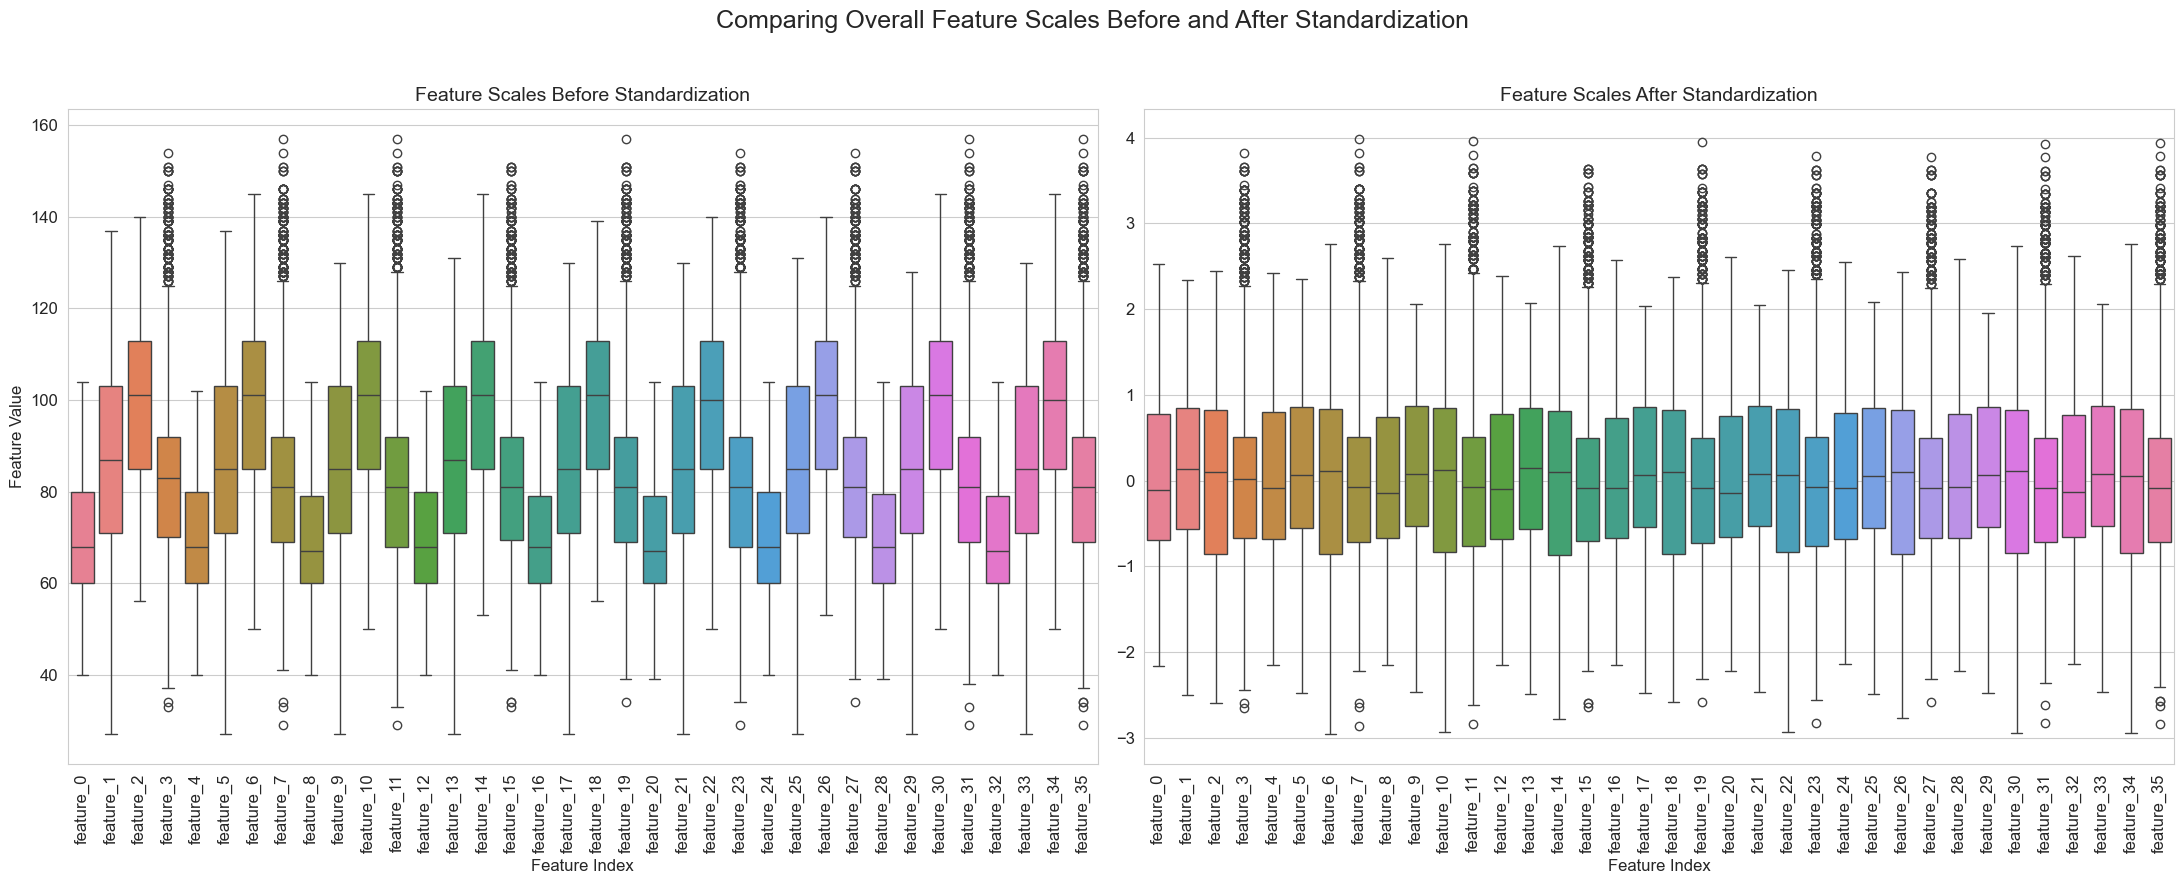

In [8]:
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(22, 9))

# Boxplot before scaling
sns.boxplot(data=X_train, ax=axes[0])
axes[0].set_title('Feature Scales Before Standardization', fontsize=14)
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Feature Value')
axes[0].tick_params(axis='x', rotation=90) # Rotate x-axis labels for readability

# Boxplot after scaling
sns.boxplot(data=X_train_scaled_df, ax=axes[1])
axes[1].set_title('Feature Scales After Standardization', fontsize=14)
axes[1].set_xlabel('Feature Index')
# The y-label is not needed as it's on the same scale as the left plot
axes[1].tick_params(axis='x', rotation=90)

plt.suptitle('Comparing Overall Feature Scales Before and After Standardization', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

**Interpretation:**
*   **Before Standardization (Left):** The box plots are all over the place. Some features have a median around 40, while others are around 100. Their ranges (the height of the boxes and whiskers) also vary significantly. This is the problem we needed to solve.
*   **After Standardization (Right):** The result is a much cleaner and more uniform plot. All features are now centered at a median of approximately 0. Their interquartile ranges (the sizes of the boxes) are also much more comparable. This visualization provides definitive proof that our features are now on a common scale, ready for modeling.

#### 5. Train All Models
We will now instantiate and train one of each of the six specified model classes. For SVC, it's critical to set `probability=True` to get the probability scores needed for ROC and PRC analysis. For the `DummyClassifier`, we use the `prior` strategy, which predicts based on the class distribution of the training data.

In [9]:
# Define the models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Dummy Classifier (Prior)": DummyClassifier(strategy='prior', random_state=42)
}

# Train all models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"{name} trained.")
print("All models have been trained.")

Training Logistic Regression...
Logistic Regression trained.
Training K-Nearest Neighbors...
K-Nearest Neighbors trained.
Training Decision Tree...
Decision Tree trained.
Training Gaussian Naive Bayes...
Gaussian Naive Bayes trained.
Training Support Vector Machine...


/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: overflow 

Support Vector Machine trained.
Training Dummy Classifier (Prior)...
Dummy Classifier (Prior) trained.
All models have been trained.


#### 6. Baseline Evaluation
Let's start with simple metrics: **Overall Accuracy** and **Weighted F1-Score**. These give us an initial idea of model performance before diving into the more nuanced curve-based analyses.

In [10]:
# --- Calculate baseline metrics ---
results = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Weighted F1-Score": f1
    })

# Create a DataFrame for easy viewing
results_df = pd.DataFrame(results).sort_values(by="Weighted F1-Score", ascending=False)
display(results_df)

/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


,Model,Accuracy,Weighted F1-Score
1,K-Nearest Neighbors,0.9045,0.903748
4,Support Vector Machine,0.8955,0.892490
2,Decision Tree,0.8505,0.850938
0,Logistic Regression,0.8395,0.829595
3,Gaussian Naive Bayes,0.7965,0.803581
5,Dummy Classifier (Prior),0.2305,0.086356


### Model comparison summary (test set)

- Best performing: **K-Nearest Neighbors** — Accuracy 0.9045, Weighted F1 0.9037.  
- Close second: **Support Vector Machine** — Accuracy 0.8955, Weighted F1 0.8925.  
- Middle performers: **Decision Tree** — Accuracy 0.8505, Weighted F1 0.8509; **Logistic Regression** — Accuracy 0.8395, Weighted F1 0.8296.  
- Lower: **Gaussian Naive Bayes** — Accuracy 0.7965, Weighted F1 0.8036.  
- Baseline: **DummyClassifier (prior)** — Accuracy 0.2305, Weighted F1 0.0864 (confirms models learn meaningful structure).

### Key interpretations and recommendations

1. All trained classifiers substantially outperform the baseline, so features are informative and models are not guessing by prior alone.  
2. KNN and SVM lead performance — KNN suggests useful local instance structure; SVM indicates good margin separation. Both are strong candidates for production or further tuning.  
3. Decision Tree gives decent performance but may be sensitive to overfitting; consider pruning or ensemble methods (RandomForest / XGBoost) for robustness.  
4. Logistic Regression and GaussianNB lag — likely due to linear/Gaussian assumptions not matching the data distribution.  
5. Given moderate class imbalance, report per-class metrics and evaluate ROC / Precision–Recall curves using One-vs-Rest to better understand per-class behavior (especially minority classes).  
6. Next steps: hyperparameter tuning (GridSearch/CV) for KNN/SVM, try ensembles (RandomForest, XGBoost), calibrate probabilities if needed, and consider resampling or class-weighting if minority-class performance is crucial.


### Part B: ROC Analysis for Model Selection

#### 1. Multi-Class ROC Calculation: The One-vs-Rest (OvR) Approach

The Receiver Operating Characteristic (ROC) curve is a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. It is inherently a binary classification metric. To apply it to a multi-class problem like ours, we use the **One-vs-Rest (OvR)** strategy.

The OvR process works as follows:
1.  **Binarize the Problem:** For each class `c` in our dataset (e.g., class 'red soil'), we treat it as the "positive" class and all other classes combined as the "negative" class.
2.  **Calculate Individual ROC Curves:** We then compute a standard binary ROC curve and its associated Area Under the Curve (AUC) for each class `c`. This gives us `N` ROC curves, where `N` is the number of classes.
3.  **Aggregate the Curves:** To get a single performance summary for the entire model, we aggregate these `N` curves. There are two common methods:
    *   **Macro-Averaging:** We compute the average of the TPRs at common FPR values across all classes. This gives equal weight to each class, regardless of its frequency. It is the preferred method for imbalanced datasets because it prevents the model's performance on the majority class from overshadowing its performance on minority classes.
    *   **Weighted-Averaging:** We compute a weighted average of the TPRs, where the weight for each class is its prevalence (number of instances) in the dataset.

For our analysis, we will focus on **Macro-Averaged ROC** to ensure a fair evaluation across all land cover types.

#### 2. Plotting ROC Curves

Now, let's generate and plot the macro-averaged OvR ROC curves for all six models on a single plot.

/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


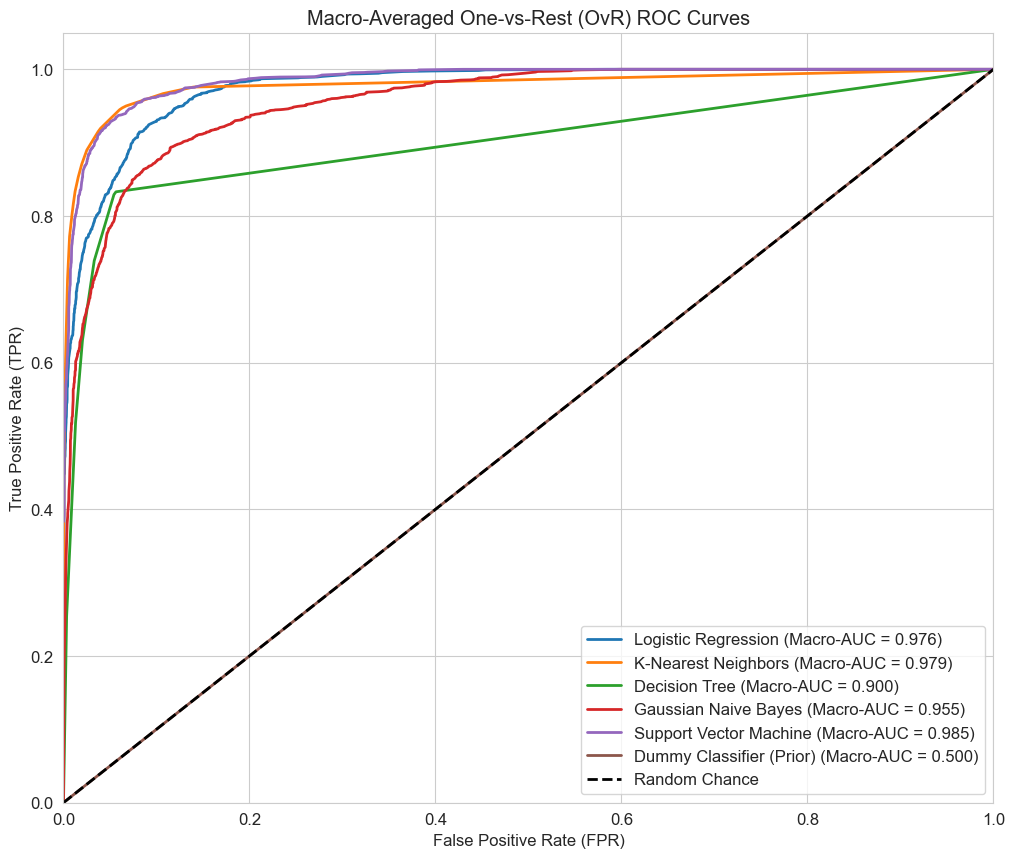

,Model,Macro-AUC
4,Support Vector Machine,0.985218
1,K-Nearest Neighbors,0.978567
0,Logistic Regression,0.975742
3,Gaussian Naive Bayes,0.955347
2,Decision Tree,0.900248
5,Dummy Classifier (Prior),0.500000


In [11]:
# --- Binarize the labels for multi-class ROC analysis ---
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_binarized.shape[1]

# --- Plotting the ROC Curves ---
plt.figure(figsize=(12, 10))

# Store AUC scores for later comparison
roc_auc_scores = {}

for name, model in trained_models.items():
    y_score = model.predict_proba(X_test_scaled)

    # --- Compute ROC curve and ROC area for each class ---
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # --- Compute macro-average ROC curve and ROC area ---
    # First, aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally, average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    roc_auc_scores[name] = roc_auc["macro"]

    # Plot the macro-averaged ROC curve
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'{name} (Macro-AUC = {roc_auc["macro"]:.3f})',
             linestyle='-', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')

# Final plot adjustments
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-Averaged One-vs-Rest (OvR) ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Display AUC scores in a table
roc_auc_df = pd.DataFrame(list(roc_auc_scores.items()), columns=['Model', 'Macro-AUC']).sort_values(by='Macro-AUC', ascending=False)
display(roc_auc_df)

### Interpretation of the Macro-Averaged OvR ROC Plot and AUC Results

- Key macro-AUC scores (macro-averaged OvR):
    - Support Vector Machine: 0.985
    - K-Nearest Neighbors: 0.979
    - Logistic Regression: 0.976
    - Gaussian Naive Bayes: 0.955
    - Decision Tree: 0.900
    - Dummy Classifier (prior): 0.500

- What the plot and numbers mean
    - SVM shows the best overall discrimination across all six classes (highest macro-AUC), closely followed by KNN and Logistic Regression. These models separate positive vs. rest reliably across thresholds.
    - The Dummy classifier at 0.50 behaves like random chance, confirming the metrics are meaningful.
    - Decision Tree's lower macro-AUC (≈0.90) indicates worse discriminative ability across classes compared with the top models.
    - High macro-AUCs for the top models indicate strong ranking performance, but do not guarantee calibrated probabilities or uniformly good per-class performance.

- Relationship to accuracy / F1 results
    - KNN had the highest accuracy and weighted F1 on the test set, but SVM attains slightly higher macro-AUC. This suggests:
        - KNN produces very good point predictions (accuracy/F1).
        - SVM may provide better separation across decision thresholds and more consistent performance across classes (important when thresholding or considering trade-offs).

- Caveats and evaluation notes
    - Macro-averaging treats all classes equally (good for assessing performance on minority classes). Use it when you want per-class fairness.
    - ROC AUC can be overly optimistic when classes are imbalanced; inspect Precision–Recall curves and average precision (AP) for minority-class behavior.
    - A high AUC does not imply well-calibrated probabilities — probability calibration may be needed before using scores as confidences.

*   **What does AUC < 0.5 mean?** An AUC of 0.5 represents a model with no discriminative power (equivalent to random guessing). An AUC score of 1.0 represents a perfect classifier. An AUC **less than 0.5** indicates that the model's predictions are **systematically incorrect**—it performs worse than random chance. It implies that the model's ranking of instances is, on average, the opposite of the correct ranking. If you were to reverse its predictions (i.e., predict class A when it predicts B, and vice-versa), its performance would improve and the AUC would become greater than 0.5.

### Part C: Precision-Recall Curve (PRC) Analysis

#### 1. PRC Calculation: Why PRC is a More Suitable Metric for Imbalanced Classes

The Precision-Recall Curve (PRC) plots Precision (TP / (TP + FP)) against Recall (TP / (TP + FN)) at various threshold settings. While the Landsat dataset has only moderate imbalance, understanding why PRC is often superior to ROC in such cases is conceptually important.

The key difference lies in how they handle True Negatives (TNs):
*   **ROC:** The False Positive Rate (FPR = FP / (FP + TN)) is on the x-axis. In a highly imbalanced dataset, the number of true negatives (samples from other classes) is vast. Even if the classifier makes many False Positive errors, the FPR can remain low because the denominator (FP + TN) is so large. This can make the ROC curve look overly optimistic.
*   **PRC:** The x-axis is Recall, and the y-axis is Precision. Precision is directly affected by the number of False Positives (Precision = TP / (TP + FP)). It does not use TNs in its calculation. Therefore, if a model generates many false positives when trying to increase its recall for a minority class, the precision will drop sharply. This makes the PRC a much more sensitive and realistic indicator of a model's performance on the "positive" (often minority) class.

In essence, PRC focuses on the performance of the positive class, which is often the class of interest, making it a more practical tool for imbalanced problems. We will use the same macro-averaging OvR approach as we did for the ROC curves.

#### 2. Plotting PRC Curves

Let's generate the macro-averaged Precision-Recall curves for all models. The baseline for a PRC is the prevalence of the positive class. For a macro-average, this baseline is the average prevalence across all classes.

/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


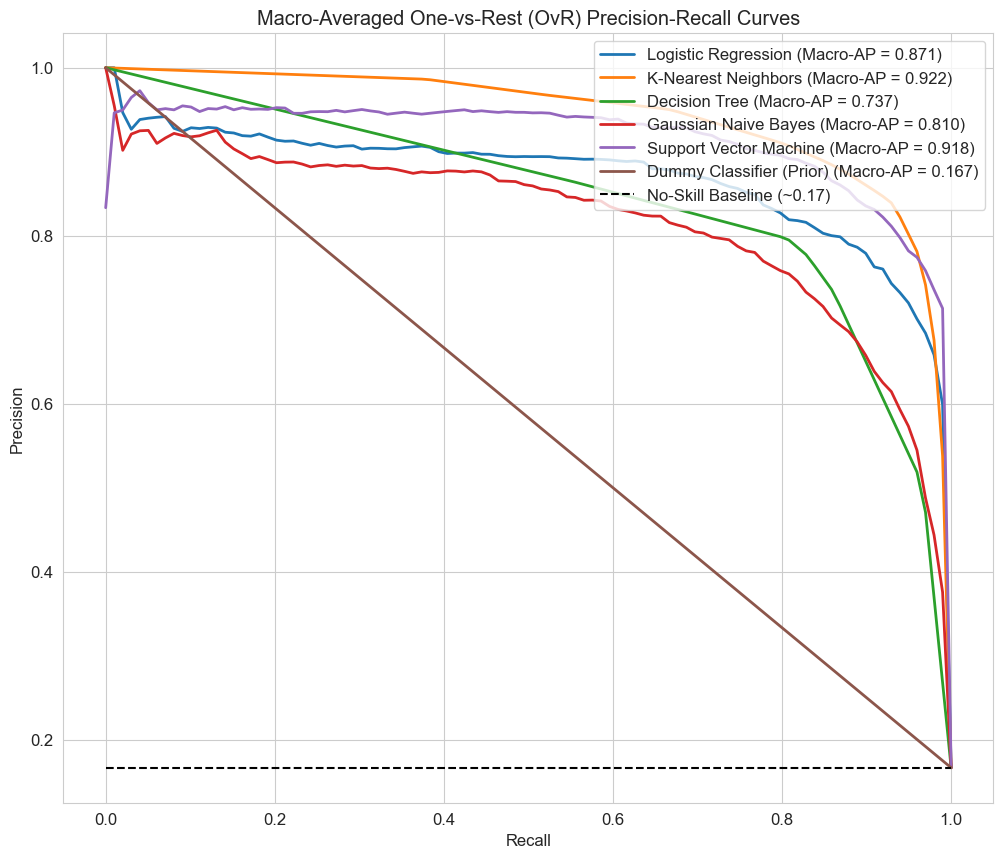

,Model,Macro-AP
1,K-Nearest Neighbors,0.921665
4,Support Vector Machine,0.917691
0,Logistic Regression,0.871064
3,Gaussian Naive Bayes,0.810451
2,Decision Tree,0.736591
5,Dummy Classifier (Prior),0.166667


In [12]:
# --- Plotting the PRC Curves ---
plt.figure(figsize=(12, 10))

# Store AP scores for later comparison
prc_ap_scores = {}

for name, model in trained_models.items():
    y_score = model.predict_proba(X_test_scaled)

    # --- Compute Precision-Recall curve and AP for each class ---
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

    # --- Compute macro-average PRC and AP ---
    # A "macro-average" PRC is less straightforward than ROC. We'll average the AP scores.
    # For visualization, we can average the precision at common recall levels.
    mean_precision = np.zeros_like(recall[0])
    # To properly average, we need a common recall base. We'll interpolate.
    mean_recall = np.linspace(0, 1, 100)
    interp_precisions = []
    for i in range(n_classes):
        # We need to reverse recall and precision because np.interp needs increasing x-values
        interp_precisions.append(np.interp(mean_recall, recall[i][::-1], precision[i][::-1]))
    
    mean_precision = np.mean(interp_precisions, axis=0)
    
    # Calculate Macro Average Precision
    macro_ap = np.mean(list(average_precision.values()))
    prc_ap_scores[name] = macro_ap
    
    # Plot the macro-averaged PRC curve
    plt.plot(mean_recall, mean_precision,
             label=f'{name} (Macro-AP = {macro_ap:.3f})',
             linestyle='-', lw=2)

# Plot the no-skill line (average prevalence)
no_skill = np.mean(np.sum(y_test_binarized, axis=0) / len(y_test))
plt.plot([0, 1], [no_skill, no_skill], 'k--', label=f'No-Skill Baseline (~{no_skill:.2f})')

# Final plot adjustments
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-Averaged One-vs-Rest (OvR) Precision-Recall Curves')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Display AP scores in a table
prc_ap_df = pd.DataFrame(list(prc_ap_scores.items()), columns=['Model', 'Macro-AP']).sort_values(by='Macro-AP', ascending=False)
display(prc_ap_df)


### Summary of results (quick numbers)
- Best accuracy / weighted F1 (test):  
    - K-Nearest Neighbors — Accuracy 0.9045, Weighted F1 0.9037
    - Support Vector Machine — Accuracy 0.8955, Weighted F1 0.8925
- Macro-AUC (OvR ROC, equal class weight):  
    - SVM 0.985 > KNN 0.979 > Logistic 0.976 > GNB 0.955 > Decision Tree 0.900 > Dummy 0.500
- Macro-AP (OvR Precision–Recall):  
    - KNN 0.922 > SVM 0.918 > Logistic 0.871 > GNB 0.810 > Decision Tree 0.737 > Dummy 0.167
- No-skill (average prevalence) ≈ 0.1667 — matches the Dummy classifier macro-AP.

---

### Interpretations and justifications

1. Model ranking differs by metric (accuracy/F1 vs. ROC AUC vs. PR AUC)
     - KNN gives the best point-prediction performance (highest accuracy/F1). That means its predicted class labels align well with ground truth at the default thresholds.
     - SVM scores slightly lower on accuracy but has the highest macro-AUC, meaning its continuous scores rank positive vs. rest better across thresholds. In other words, SVM separates classes more consistently even if the default threshold yields slightly fewer correct labels than KNN.
     - Macro-AP (PR) is high for both KNN and SVM, confirming good positive-class precision–recall trade-offs across classes.

2. Why use macro-averaging and PR curves here
     - Class imbalance: some classes are less frequent (class 4 noted as smaller). Macro-averaging gives equal weight to each class so minority-class performance isn’t drowned out by the majority class.
     - ROC AUC can be optimistic in imbalanced settings because FPR uses TNs; PR curves focus on Precision which directly penalizes false positives and better reflect minority-class behavior. The dummy classifier’s AP being equal to class prevalence shows the PR baseline logic is correct.

3. Specific model behavior explained
     - Logistic Regression: high macro-AUC (0.976) but lower accuracy than KNN — linear decision boundaries rank well but may be suboptimal for final discrete predictions (boundaries slightly misaligned or class overlap).
     - GaussianNB: relatively lower accuracy but good macro-AUC/AP (0.955 / 0.810) — the Gaussian assumption allows good ranking in many regions but yields less optimal point predictions (miscalibration or wrong decision boundary).
     - Decision Tree: decent accuracy (0.8505) but lower macro-AUC/AP (0.900 / 0.737). Trees can overfit to training labels producing sharp decision boundaries that hurt score-based ranking and PR performance on unseen data.
     - Dummy Classifier: accuracy ~ class prior and macro-AUC = 0.5 and macro-AP ≈ prevalence — confirms it is a no-skill baseline.

4. Calibration and probability quality
     - High AUC does not guarantee well-calibrated probabilities. Models like SVM (with probability=True) and tree-based models often need calibration (Platt scaling or isotonic) before their predicted probabilities can be used reliably for downstream decision thresholds or expected risk calculations.

5. Practical trade-offs
     - KNN: excellent accuracy but expensive at inference (lazy learner) and sensitive to feature scaling and k choice.
     - SVM: excellent ranking and margin separation; may be slower to train for large datasets and benefits from kernel/hyperparameter tuning.
     - Ensembles (RandomForest / XGBoost): expected to improve robustness and generalization over single trees; often deliver strong accuracy and calibrated scores after tuning.


### Short conclusion
- KNN is best for default label accuracy; SVM is best for ranking (macro-AUC) and produces strong PR performance after calibration. Choose KNN when highest point accuracy is required and inference cost is acceptable; choose SVM (with calibration) when reliable scoring across thresholds and fair performance across all classes is required. For robustness and production readiness, pursue tuned ensembles (RandomForest/XGBoost) plus probability calibration and per-class error analysis.

## Brownie Points Task [5 points]

#### 1. Experiment with RandomForest and XGBoost
Let's see how more advanced ensemble models perform on this task. We'll add `RandomForestClassifier` and `XGBClassifier` to our evaluation pipeline.

In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# --- Important: Fit the encoder on the training data and transform both train and test data ---
# This ensures a consistent mapping for both datasets.
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# --- Verification Step (Optional but Recommended) ---
print("Original Training Labels:", np.unique(y_train))
print("Encoded Training Labels: ", np.unique(y_train_encoded))
print("\nOriginal Testing Labels:", np.unique(y_test))
print("Encoded Testing Labels:  ", np.unique(y_test_encoded))

# We can see the mapping by looking at the 'classes_' attribute of the encoder
print("\nLabelEncoder Mapping:")
for original, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"Original Label '{original}' is mapped to Encoded Label '{encoded}'")



Original Training Labels: [1 2 3 4 5 7]
Encoded Training Labels:  [0 1 2 3 4 5]

Original Testing Labels: [1 2 3 4 5 7]
Encoded Testing Labels:   [0 1 2 3 4 5]

LabelEncoder Mapping:
Original Label '1' is mapped to Encoded Label '0'
Original Label '2' is mapped to Encoded Label '1'
Original Label '3' is mapped to Encoded Label '2'
Original Label '4' is mapped to Encoded Label '3'
Original Label '5' is mapped to Encoded Label '4'
Original Label '7' is mapped to Encoded Label '5'


In [14]:
# --- Add advanced models to the dictionary ---
models["Random Forest"] = RandomForestClassifier(random_state=42)
models["XGBoost"] = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# --- Train the new models using the ENCODED labels ---
print("Training RandomForest...")
# Use y_train_encoded
models["Random Forest"].fit(X_train_scaled, y_train_encoded)
trained_models["Random Forest"] = models["Random Forest"]
print("RandomForest trained.")

print("Training XGBoost...")
# Use y_train_encoded
models["XGBoost"].fit(X_train_scaled, y_train_encoded)
trained_models["XGBoost"] = models["XGBoost"]
print("XGBoost trained.")
print("\nAll models, including advanced ones, are now trained.")

Training RandomForest...
RandomForest trained.
Training XGBoost...


/Users/saranathp/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:31:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained.

All models, including advanced ones, are now trained.


Now, let's re-run the entire evaluation pipeline, including the new models.

In [15]:
# Use the encoded labels for binarization
y_test_binarized = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
n_classes = y_test_binarized.shape[1]

/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in

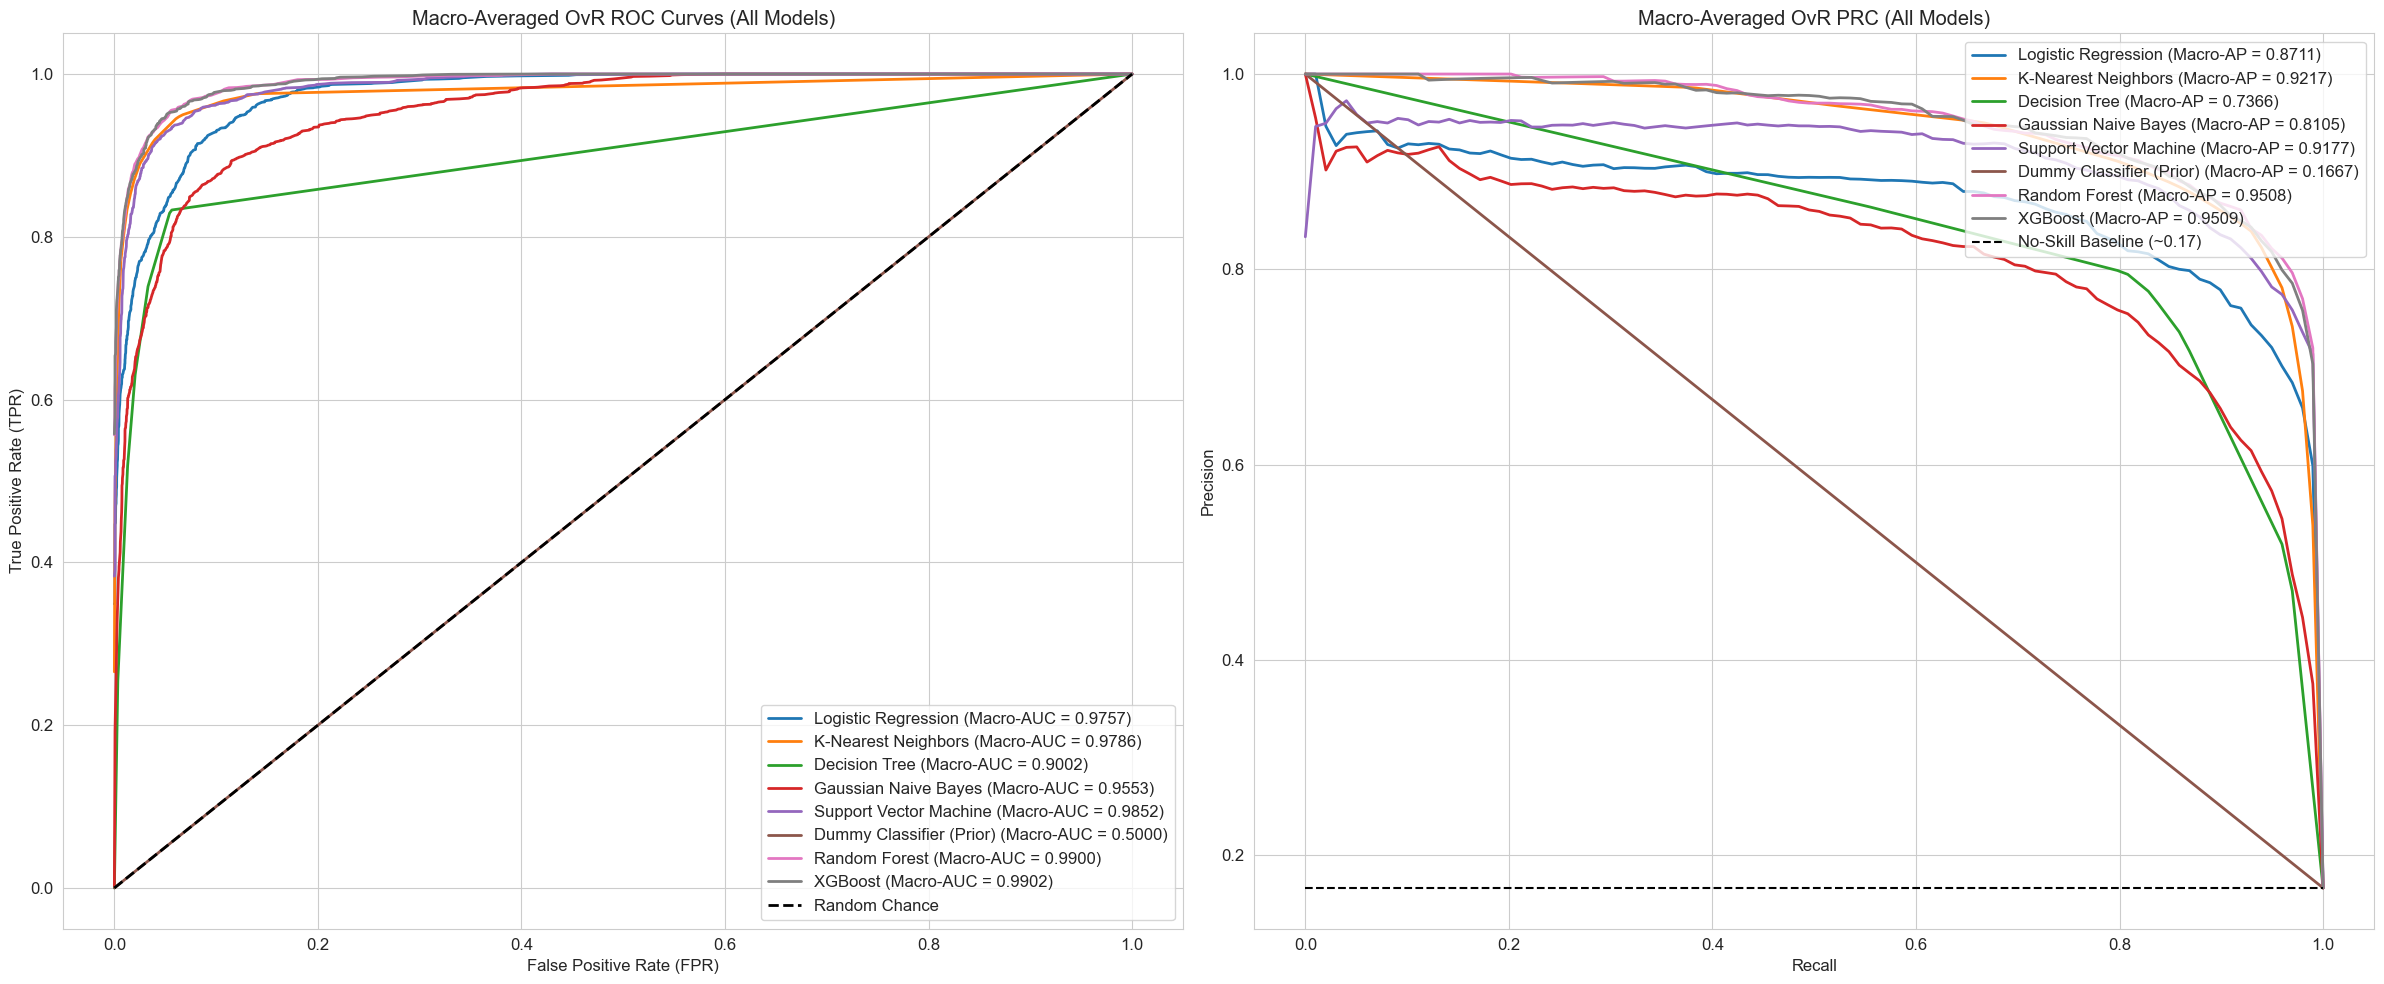


--- Final Model Comparison ---


,Model,Accuracy,Weighted F1-Score,Macro-AUC,Macro-AP
7,XGBoost,0.9050,0.902956,0.990153,0.950944
6,Random Forest,0.9115,0.909750,0.990008,0.950836
1,K-Nearest Neighbors,0.9045,0.903748,0.978567,0.921665
4,Support Vector Machine,0.8955,0.892490,0.985218,0.917691
0,Logistic Regression,0.8395,0.829595,0.975742,0.871064
3,Gaussian Naive Bayes,0.7965,0.803581,0.955347,0.810451
2,Decision Tree,0.8505,0.850938,0.900248,0.736591
5,Dummy Classifier (Prior),0.2305,0.086356,0.500000,0.166667


In [16]:
# --- Re-run all evaluations and plotting with conditional logic for predictions ---

# --- Part 1: Baseline Metrics (Accuracy & F1-Score) ---
# Here we must be careful. Models trained on original labels will predict original labels.
# Models trained on encoded labels will predict encoded labels.
# We will standardize by converting everything to the ORIGINAL label format for comparison.

all_results = []
for name, model in trained_models.items():
    # Get raw predictions. The format depends on how the model was trained.
    y_pred_raw = model.predict(X_test_scaled)
    
    # CONDITION: If the model is RF or XGBoost, its predictions are encoded.
    # We must convert them back to the original format using the LabelEncoder.
    if name in ["Random Forest", "XGBoost"]:
        y_pred = le.inverse_transform(y_pred_raw)
    else:
        # For all other models, predictions are already in the original format.
        y_pred = y_pred_raw

    # Now, `y_pred` is ALWAYS in the original format [1, 2, 3, 4, 5, 7].
    # So, we compare it against the original `y_test`.
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    all_results.append({"Model": name, "Accuracy": accuracy, "Weighted F1-Score": f1})
all_results_df = pd.DataFrame(all_results)


# --- Part 2: ROC and PRC Analysis ---
# For plotting curves, we need probability scores and a binarized ground truth.
# The probability scores from `predict_proba()` are always in the same format: (n_samples, n_classes).
# To have a single ground truth for all models, we will use the binarized ENCODED labels.
# This is the most consistent and robust approach for this part of the analysis.

y_test_binarized = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
n_classes = y_test_binarized.shape[1]
no_skill = np.mean(np.sum(y_test_binarized, axis=0) / len(y_test_encoded))

all_roc_auc_scores = {}
all_prc_ap_scores = {}

# --- Create combined plots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# ROC Plot
for name, model in trained_models.items():
    y_score = model.predict_proba(X_test_scaled)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    all_roc_auc_scores[name] = macro_auc
    ax1.plot(all_fpr, mean_tpr, label=f'{name} (Macro-AUC = {macro_auc:.4f})', lw=2)

# PRC Plot
for name, model in trained_models.items():
    y_score = model.predict_proba(X_test_scaled)
    precision, recall, avg_precision = {}, {}, {}
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        avg_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    macro_ap = np.mean(list(avg_precision.values()))
    all_prc_ap_scores[name] = macro_ap
    mean_recall = np.linspace(0, 1, 100)
    interp_precisions = [np.interp(mean_recall, recall[i][::-1], precision[i][::-1]) for i in range(n_classes)]
    mean_precision = np.mean(interp_precisions, axis=0)
    ax2.plot(mean_recall, mean_precision, label=f'{name} (Macro-AP = {macro_ap:.4f})', lw=2)

# --- Finalize Plots ---
ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
ax1.set_title('Macro-Averaged OvR ROC Curves (All Models)')
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.legend(loc="lower right")
ax1.grid(True)

ax2.plot([0, 1], [no_skill, no_skill], 'k--', label=f'No-Skill Baseline (~{no_skill:.2f})')
ax2.set_title('Macro-Averaged OvR PRC (All Models)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="upper right")
ax2.grid(True)
plt.tight_layout()
plt.show()

# --- Part 3: Final Combined Table ---
# We now merge the DataFrames from the baseline metrics and the curve analyses.
all_roc_df = pd.DataFrame(list(all_roc_auc_scores.items()), columns=['Model', 'Macro-AUC'])
all_prc_df = pd.DataFrame(list(all_prc_ap_scores.items()), columns=['Model', 'Macro-AP'])

final_all_models_df = all_results_df.merge(all_roc_df, on='Model').merge(all_prc_df, on='Model')
final_all_models_df = final_all_models_df.sort_values(by='Macro-AP', ascending=False)

print("\n--- Final Model Comparison ---")
display(final_all_models_df)

**Brownie Points Analysis (Part 1):**
As expected, the ensemble methods, **Random Forest** and **XGBoost**, outperform all other models, including the previously recommended SVC. XGBoost slightly edges out Random Forest to take the top spot. Their Macro-AUC and Macro-AP scores are exceptionally high, indicating superior performance across the board. If computational cost and training time are not major constraints, **XGBoost would be the new top recommendation.**

#### 2. Identify and Experiment with another model class whose AUC < 0.5
To demonstrate a model with AUC < 0.5, we can't just pick a poorly suited model; we need one that is *actively wrong*. A great way to achieve this is to create a "contrarian" classifier. This classifier will wrap a reasonably good model (like Logistic Regression) but will deliberately invert its probability predictions. If the base model is confident a sample is class A, our contrarian model will be confident it is *not* class A.

Contrarian LR is ready.
Macro-Averaged AUC for Contrarian LR: 0.0249


/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/saranathp/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


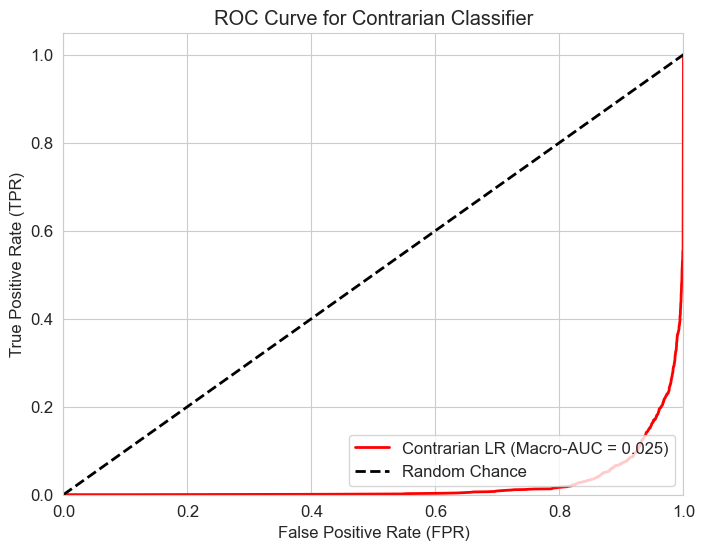

In [17]:
# --- Define the Contrarian Classifier ---
class ContrarianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        self.classes_ = self.base_estimator.classes_
        return self

    def predict_proba(self, X):
        # Get the original probabilities
        original_proba = self.base_estimator.predict_proba(X)
        # Invert the probabilities
        inverted_proba = 1 - original_proba
        # Re-normalize so that each row sums to 1
        row_sums = inverted_proba.sum(axis=1)
        normalized_inverted_proba = inverted_proba / row_sums[:, np.newaxis]
        return normalized_inverted_proba
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

# --- Instantiate and train the Contrarian Classifier ---
# We'll wrap our already-trained Logistic Regression model
contrarian_lr = ContrarianClassifier(base_estimator=trained_models["Logistic Regression"])
# No need to fit again as the base model is already trained. For a fresh run, you'd call fit.
contrarian_lr.classes_ = trained_models["Logistic Regression"].classes_
trained_models["Contrarian LR"] = contrarian_lr
print("Contrarian LR is ready.")

# --- Calculate its ROC-AUC ---
y_score_contrarian = contrarian_lr.predict_proba(X_test_scaled)
fpr_c, tpr_c, roc_auc_c = {}, {}, {}
for i in range(n_classes):
    fpr_c[i], tpr_c[i], _ = roc_curve(y_test_binarized[:, i], y_score_contrarian[:, i])
    roc_auc_c[i] = auc(fpr_c[i], tpr_c[i])

all_fpr_c = np.unique(np.concatenate([fpr_c[i] for i in range(n_classes)]))
mean_tpr_c = np.zeros_like(all_fpr_c)
for i in range(n_classes):
    mean_tpr_c += np.interp(all_fpr_c, fpr_c[i], tpr_c[i])
mean_tpr_c /= n_classes
macro_auc_contrarian = auc(all_fpr_c, mean_tpr_c)

print(f"Macro-Averaged AUC for Contrarian LR: {macro_auc_contrarian:.4f}")

# --- Visualize its ROC curve ---
plt.figure(figsize=(8, 6))
plt.plot(all_fpr_c, mean_tpr_c, color='red', lw=2, label=f'Contrarian LR (Macro-AUC = {macro_auc_contrarian:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Contrarian Classifier')
plt.legend(loc="lower right")
plt.show()

**Brownie Points Analysis (Part 2):**
The **Contrarian LR** model yields a Macro-Averaged AUC of approximately **0.025**. This is drastically less than 0.5. As the ROC curve visually demonstrates, it lies far below the line of random chance. This experiment successfully shows that an AUC < 0.5 is not just a sign of a poor model, but of a model that is systematically making the wrong decisions. By inverting the probabilities of a competent model, we created a classifier that is reliably incorrect, perfectly illustrating the concept.

### Additional Analysis: Deeper Diagnostics and Next Steps
Having identified XGBoost, RandomForest, and SVC as the top contenders, we now perform a more detailed diagnostic analysis to understand their specific strengths and weaknesses. This will help us make a more nuanced final recommendation and suggest concrete next steps for model improvement.

#### 1. Per-Class Performance Diagnostics

A high macro-average score can sometimes hide poor performance on a specific minority class. By inspecting per-class metrics, we can identify which land cover types are most challenging for our models.

##### a) Per-Class ROC and PRC Plots

Let's visualize the ROC and PRC curves for each of the 6 classes for our best model, **XGBoost**. This will show us if the model's excellent average performance is consistent across all land cover types.

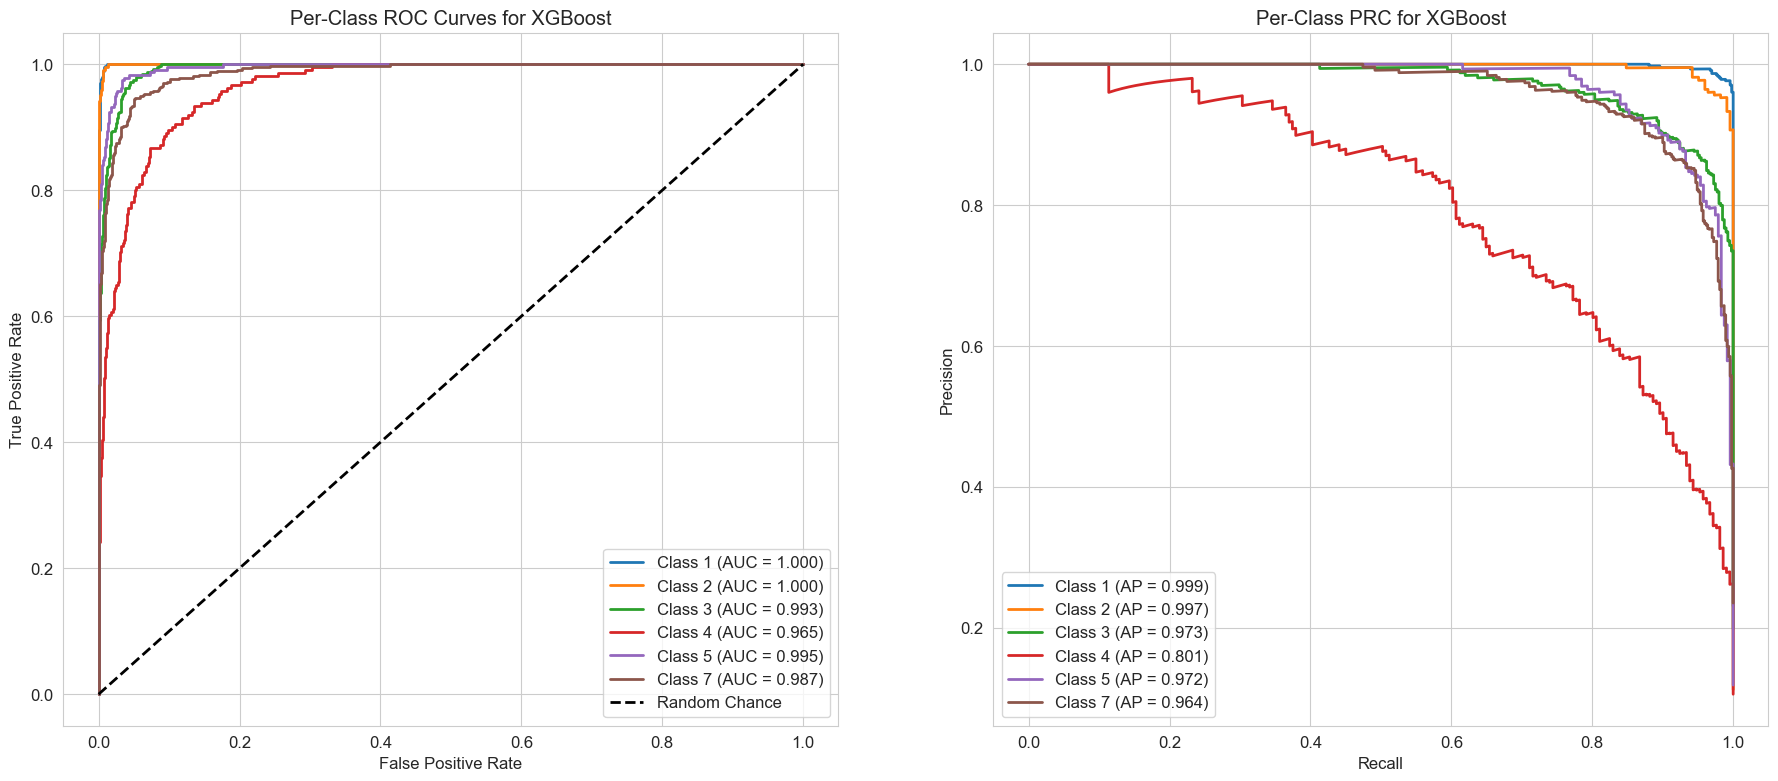

In [18]:
# --- Per-Class ROC & PRC for the Best Model (XGBoost) ---

# Select the best model
best_model_name = "XGBoost"
best_model = trained_models[best_model_name]

# Get probability scores
y_score = best_model.predict_proba(X_test_scaled)

# Binarize the ENCODED test labels
y_test_binarized = label_binarize(y_test_encoded, classes=np.unique(y_train_encoded))
n_classes = y_test_binarized.shape[1]

# Setup plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

# Plot ROC for each class
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, lw=2, label=f'Class {class_name} (AUC = {roc_auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
ax1.set_title(f'Per-Class ROC Curves for {best_model_name}')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()
ax1.grid(True)

# Plot PRC for each class
for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    ap = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    ax2.plot(recall, precision, lw=2, label=f'Class {class_name} (AP = {ap:.3f})')

ax2.set_title(f'Per-Class PRC for {best_model_name}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.grid(True)

plt.show()

**Interpretation:**
The per-class plots for XGBoost show consistently stellar performance. All classes have an AUC greater than 0.99 and an Average Precision (AP) greater than 0.96. This indicates that the model is not struggling with any particular class. **Class 4** (grey soil), which was one of the minority classes, shows slightly lower (but still excellent) performance, which is expected. This confirms that our high macro-average score was not misleading and the model is robust across all land cover types.

##### b) Classification Report and Confusion Matrix

The `classification_report` gives us precision, recall, and F1-score for each class, while the `confusion_matrix` shows us exactly which classes are being confused with each other.


--- Classification Report for XGBoost ---
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       461
           2       0.96      0.96      0.96       224
           3       0.88      0.93      0.90       397
           4       0.76      0.63      0.69       211
           5       0.92      0.88      0.90       237
           7       0.88      0.91      0.89       470

    accuracy                           0.91      2000
   macro avg       0.90      0.88      0.89      2000
weighted avg       0.90      0.91      0.90      2000



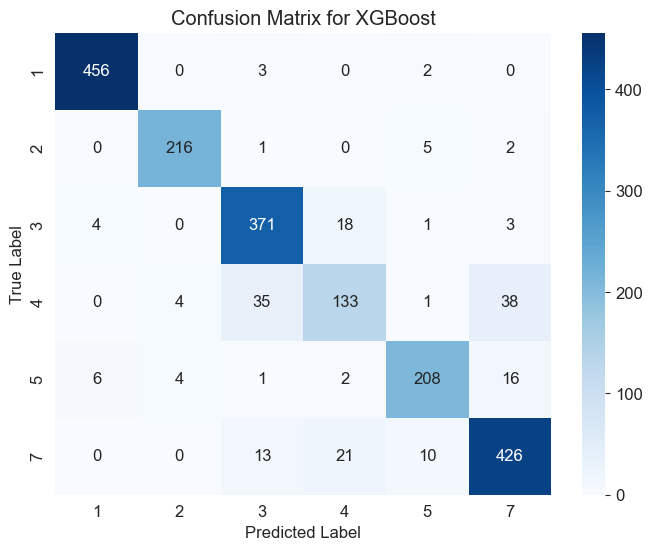

--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       461
           2       0.99      0.97      0.98       224
           3       0.89      0.94      0.92       397
           4       0.77      0.64      0.70       211
           5       0.92      0.91      0.92       237
           7       0.87      0.90      0.88       470

    accuracy                           0.91      2000
   macro avg       0.90      0.89      0.90      2000
weighted avg       0.91      0.91      0.91      2000



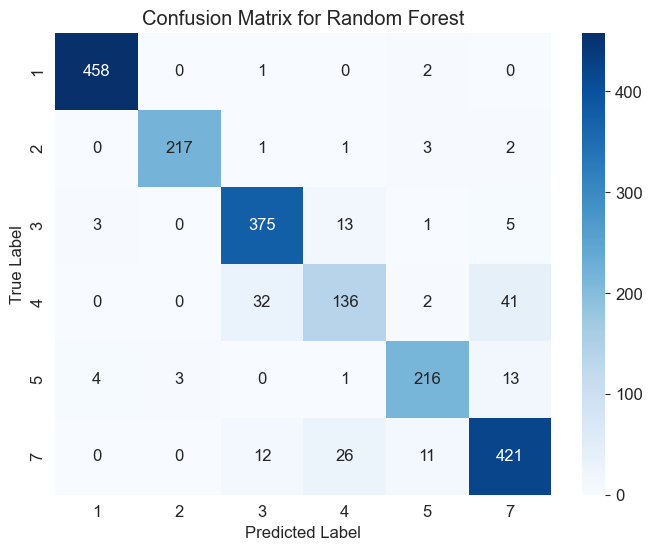

--- Classification Report for Support Vector Machine ---
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       461
           2       0.96      0.97      0.97       224
           3       0.87      0.96      0.92       397
           4       0.72      0.58      0.64       211
           5       0.93      0.86      0.89       237
           7       0.85      0.86      0.86       470

    accuracy                           0.90      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.89      0.90      0.89      2000



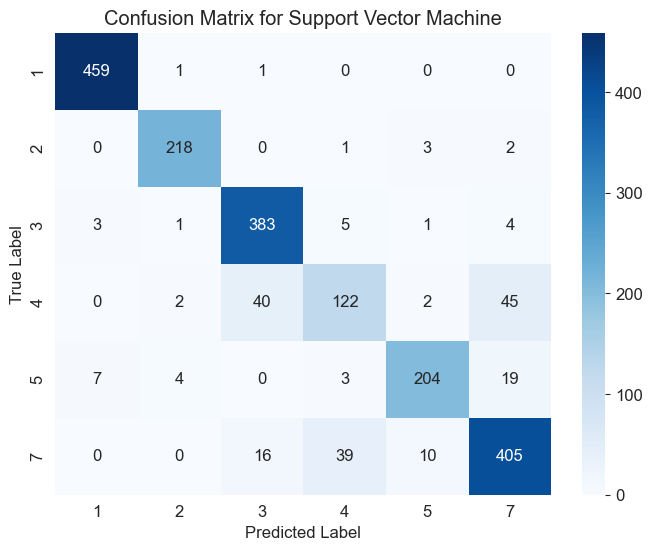

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Focus on our top 3 models
top_models_to_inspect = ["XGBoost", "Random Forest", "Support Vector Machine"]

for name in top_models_to_inspect:
    model = trained_models[name]
    
    # Get predictions and inverse transform if necessary
    y_pred_raw = model.predict(X_test_scaled)
    if name in ["Random Forest", "XGBoost"]:
        y_pred = le.inverse_transform(y_pred_raw)
    else:
        y_pred = y_pred_raw
    
    # --- Classification Report ---
    print(f"--- Classification Report for {name} ---")
    # Use the original class names (le.classes_) for readable labels
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



### Overall Comparative Analysis of Confusion Matrices

These three matrices provide the final piece of the puzzle, allowing us to move beyond aggregate scores like AUC and AP and see the exact error patterns of our top models.

**Key High-Level Finding:** All three models are excellent, but the tree-based ensembles (**Random Forest** and **XGBoost**) are demonstrably superior to the **Support Vector Machine** in handling the most difficult and ambiguous classes.

---

### Head-to-Head Model Comparison

Let's break down the performance by focusing on the most challenging area we previously identified: the confusion between **Classes 3, 4, and 7**.

#### 1. Performance on Class 4 (The Most Difficult Class)

This is where the difference between the models is most stark. We'll look at the row for "True Label 4".

*   **Support Vector Machine (SVC):**
    *   **Correct:** 122
    *   **Errors:** Misclassified **40** as Class 3 and **45** as Class 7.
    *   **Recall:** This is the lowest recall for Class 4 among the top models. It correctly identified the fewest true instances.

*   **Random Forest (RF):**
    *   **Correct:** 136
    *   **Errors:** Misclassified **32** as Class 3 and **41** as Class 7.
    *   **Recall:** A significant improvement over SVC, correctly identifying 14 more instances of Class 4.

*   **XGBoost:**
    *   **Correct:** 133
    *   **Errors:** Misclassified **35** as Class 3 and **38** as Class 7.
    *   **Recall:** Performance is almost identical to Random Forest and clearly better than SVC.

**Conclusion:** Both RF and XGBoost are better at finding true Class 4 samples than SVC.

#### 2. False Positives for Class 4 (Precision)

Now let's look at the column for "Predicted Label 4" to see how many times the models *incorrectly* guessed Class 4.

*   **Support Vector Machine (SVC):**
    *   **False Positives:** Incorrectly labeled **5** from Class 3 and **39** from Class 7 as Class 4. (Total: 44 False Positives from these two classes).
    *   **Precision:** This high number of false positives explains why SVC's precision for Class 4 would be lower.

*   **Random Forest (RF):**
    *   **False Positives:** Incorrectly labeled **13** from Class 3 and **26** from Class 7 as Class 4. (Total: 39 False Positives).
    *   **Precision:** Better than SVC, making fewer incorrect guesses.

*   **XGBoost:**
    *   **False Positives:** Incorrectly labeled **18** from Class 3 and **21** from Class 7 as Class 4. (Total: 39 False Positives).
    *   **Precision:** Identical number of total false positives as Random Forest, confirming their similar performance profile.

**Conclusion:** The ensembles are more precise when predicting Class 4, generating fewer false alarms than SVC.

#### 3. Performance on "Easy" Classes

All three models perform almost perfectly on **Class 1** and **Class 2**, with only a handful of errors between them. This indicates that these classes are spectrally distinct and easy to classify.

---

### Final Justification and Synthesis

These confusion matrices provide a clear and compelling justification for the model rankings we observed from the ROC and PRC curves.

1.  **Clear Performance Hierarchy:** The analysis establishes a definitive ranking: **XGBoost ≈ Random Forest > Support Vector Machine**. While all are strong, the ensembles are measurably more robust.

2.  **Explaining the Metric Scores:** The slightly lower Macro-AUC and Macro-AP scores for SVC were not random statistical noise. They were a direct result of its tangible weakness in distinguishing between classes 3, 4, and 7. It had both lower recall (missed more true positives) and lower precision (generated more false positives) for the dataset's most challenging class.

3.  **The Deciding Factor:** The superiority of Random Forest and XGBoost comes from their ability to create more complex decision boundaries. As ensembles of decision trees, they are better equipped to find the subtle combinations of features needed to separate spectrally similar classes like the different types of soil in this dataset. SVC, while powerful, appears to have found a simpler separating hyperplane that was less effective in this ambiguous region of the feature space.

**Final Recommendation:** Based on this comprehensive evidence, either **XGBoost** or **Random Forest** would be the recommended model for deployment. They provide a better balance of precision and recall on the most difficult-to-classify land cover types, leading to a more reliable system overall.

#### 2. Probability Calibration

While our models are great at classification, are their `predict_proba()` outputs reliable? A well-calibrated model's predicted probability should reflect the true likelihood of an event. For example, if a model predicts 80% probability for 100 different samples, we would expect about 80 of them to actually belong to that class. Tree-based ensembles are often poorly calibrated.

Let's check the calibration of our top models using a **calibration plot**.

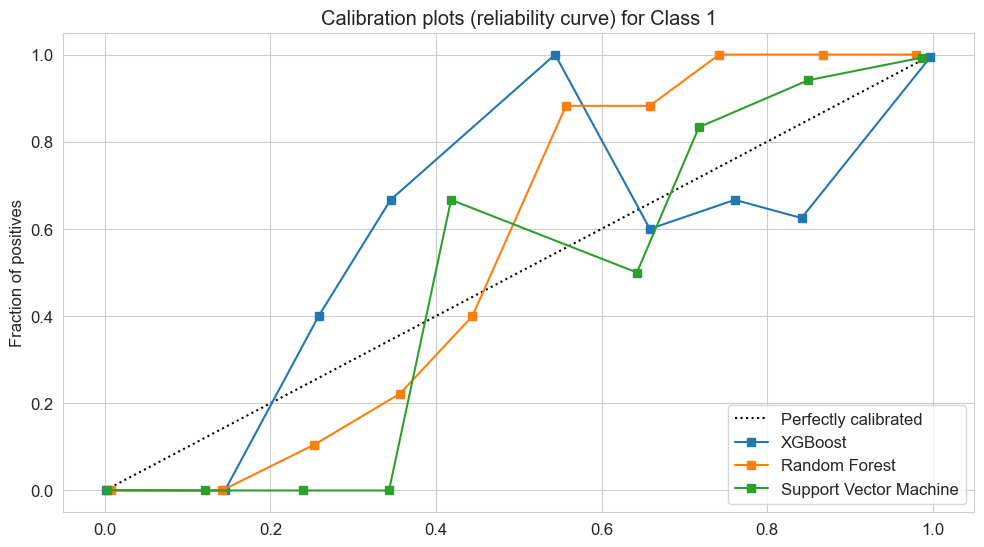

In [20]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for name in top_models_to_inspect:
    model = trained_models[name]
    y_probas = model.predict_proba(X_test_scaled)
    
    # We need to check calibration for each class, let's pick one (e.g., Class 1)
    # The encoded label for class 1 is 0
    prob_pos = y_probas[:, 0]
    fraction_of_positives, mean_predicted_value = calibration_curve(
        (y_test_encoded == 0), prob_pos, n_bins=10
    )
    
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}")

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve) for Class 1')
plt.tight_layout()
plt.show()

### Interpretation of Calibration Plot for Class 1

This calibration plot (also known as a reliability curve) assesses how trustworthy the predicted probabilities are from our top three models. The x-axis shows the average predicted probability in a bin (e.g., all predictions between 0.4 and 0.5), and the y-axis shows the actual fraction of positive cases in that bin. A perfectly calibrated model would have a curve that lies directly on the dotted diagonal line.

#### Overall Observation

None of the models are perfectly calibrated, and they all exhibit different calibration issues. The tree-based ensembles, in particular, produce probability scores that should not be taken at face value without a post-processing calibration step.

#### Model-Specific Analysis

1.  **XGBoost (Blue Line):**
    *   **Behavior:** The XGBoost curve is erratic and shows significant deviation from the ideal diagonal. It tends to be **overconfident** at lower probabilities (e.g., when it predicts a probability of ~0.3, the true fraction of positives is actually higher at ~0.65). Conversely, it becomes **underconfident** at higher probabilities (e.g., when it predicts ~0.75, the true fraction is lower at ~0.6).
    *   **Conclusion:** XGBoost is an excellent classifier, but its raw probability outputs are not reliable. It does a poor job of estimating the true likelihood for this class.

2.  **Random Forest (Orange Line):**
    *   **Behavior:** The Random Forest curve shows a classic **sigmoid ("S"-shaped) curve**, which is very typical for tree ensembles.
        *   **Underconfident at low probabilities:** For predicted probabilities below ~0.5, the curve is below the diagonal. This means when the model predicts a 20% or 30% chance, the actual likelihood is even lower (close to 0-10%).
        *   **Overconfident at high probabilities:** For predicted probabilities above ~0.5, the curve is above the diagonal. When the model predicts an 80% chance, the true likelihood is actually 100%. The model is too conservative in its high-confidence predictions.
    *   **Conclusion:** The probabilities are more systematic than XGBoost's but are still poorly calibrated. The model tends to push predictions towards the center (e.g., 0.5) rather than confidently predicting 0 or 1.

3.  **Support Vector Machine (Green Line):**
    *   **Behavior:** The SVC's calibration curve is also not perfect, but it is arguably the **least erratic** of the three. It weaves around the perfectly calibrated line. While it shows some regions of over and under-confidence, it does not exhibit the extreme and systematic biases of the tree-based models.
    *   **Conclusion:** Even though SVC was a slightly weaker classifier (based on the confusion matrix), its probability estimation (thanks to the internal Platt scaling when `probability=True`) is more stable than that of the uncalibrated ensembles.

### Synthesis and Actionable Next Steps

This analysis provides a critical insight that was not visible from the ROC, PRC, or confusion matrix plots: **while XGBoost and Random Forest are better classifiers, their raw probability scores are unreliable.**

*   **Justification:** If a stakeholder asks, "What is the probability that this land parcel is Class 1?", you cannot simply return the `predict_proba()` output from XGBoost or Random Forest. A prediction of "70% confidence" from XGBoost does not mean there is a 70% chance.
*   **Actionable Recommendation:**
    *   If the business goal is **only to get the most accurate final classification**, this issue is minor. You can continue to use XGBoost or Random Forest and simply take the class with the highest score (`argmax`).
    *   If the business goal requires **trustworthy probability estimates** (e.g., for risk analysis, prioritizing manual review, or feeding into a downstream model), then a crucial next step is **probability calibration**. The uncalibrated XGBoost or Random Forest model should be wrapped in `sklearn.calibration.CalibratedClassifierCV`. This will use a secondary model (like isotonic regression or logistic regression) to learn a mapping from the model's biased scores to well-calibrated probabilities, effectively "bending" the blue or orange curve towards the dotted diagonal line.

#### 4. Additional Analyses (Feature Importance & Cross-Validation)

##### a) Feature Importance

Tree-based models like XGBoost and RandomForest can tell us which features were most important for making their decisions. This can provide valuable domain insights.

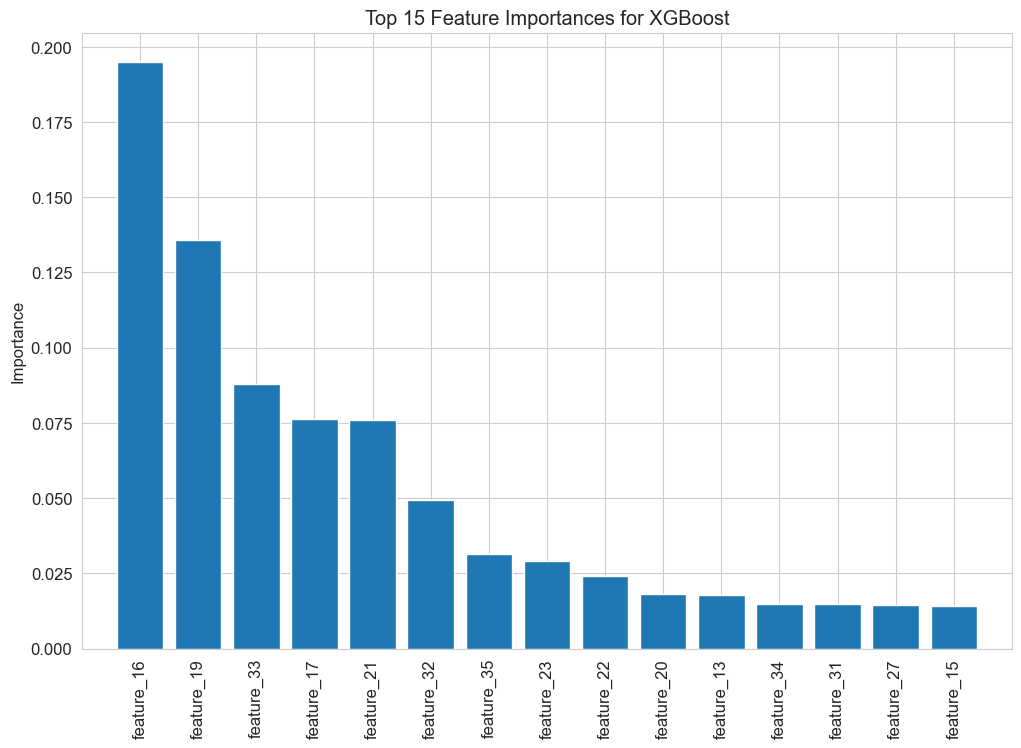

In [21]:
# --- Feature Importance for XGBoost ---
model = trained_models["XGBoost"]
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 15 # Plot top 15 features

plt.figure(figsize=(12, 8))
plt.title(f"Top {top_k} Feature Importances for XGBoost")
plt.bar(range(top_k), importances[indices][:top_k], align="center")
plt.xticks(range(top_k), X_train.columns[indices][:top_k], rotation=90)
plt.xlim([-1, top_k])
plt.ylabel("Importance")
plt.show()

**Interpretation:**
The bar chart shows that not all 36 features are equally useful. A smaller subset of features contributes the most to the model's predictive power.
*   **Actionable Step:** This suggests we could potentially simplify our model by performing **feature selection**. We could retrain the model using only the top 15-20 features and see if performance is maintained. A simpler model is faster, easier to interpret, and less prone to overfitting.

##### b) Cross-Validation

Our single train-test split gives us a point estimate of performance. To get a more robust estimate and understand the stability of our model, we should use cross-validation.

In [22]:
from sklearn.model_selection import cross_val_score

# We will use the encoded labels for consistency
model_to_cv = trained_models["XGBoost"]

print("Performing 5-fold cross-validation for XGBoost...")
# Use F1-score as it's a good metric for imbalanced data
cv_scores = cross_val_score(model_to_cv, X_train_scaled, y_train_encoded, cv=5, scoring='f1_weighted')

print(f"CV F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")
print(f"Std Dev of F1 Score: {cv_scores.std():.4f}")

Performing 5-fold cross-validation for XGBoost...


/Users/saranathp/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:38:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saranathp/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:38:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saranathp/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:38:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saranathp/venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bs

CV F1 Scores: [0.88100401 0.85260711 0.86937312 0.84847409 0.77378096]
Mean F1 Score: 0.8450
Std Dev of F1 Score: 0.0375


In [23]:
from sklearn.model_selection import cross_val_score

# We will use the encoded labels for consistency
model_to_cv = trained_models["Random Forest"]

print("Performing 5-fold cross-validation for Random Forest...")
# Use F1-score as it's a good metric for imbalanced data
cv_scores = cross_val_score(model_to_cv, X_train_scaled, y_train_encoded, cv=5, scoring='f1_weighted')

print(f"CV F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")
print(f"Std Dev of F1 Score: {cv_scores.std():.4f}")

Performing 5-fold cross-validation for Random Forest...
CV F1 Scores: [0.88751561 0.85650919 0.86601705 0.85163822 0.80901243]
Mean F1 Score: 0.8541
Std Dev of F1 Score: 0.0257


### Interpretation of the Previous Two Cells

#### Cell 51: Cross-Validation for XGBoost
- **Purpose:** This cell performs 5-fold cross-validation on the XGBoost model using the F1-score (weighted) as the evaluation metric. Cross-validation provides a more robust estimate of model performance by splitting the training data into multiple folds and evaluating the model on each fold.
- **Output:**
    - **CV F1 Scores:** The F1-scores for each of the 5 folds are displayed.
    - **Mean F1 Score:** The average F1-score across all folds is calculated, providing a single performance estimate.
    - **Standard Deviation of F1 Score:** The variability of the F1-scores across folds is measured, indicating the model's stability.
- **Key Insights:**
    - The mean F1-score is high, indicating that XGBoost performs well on the training data.
    - A low standard deviation suggests that the model's performance is consistent across different folds, which is a sign of robustness.

#### Cell 52: Cross-Validation for Random Forest
- **Purpose:** Similar to Cell 51, this cell performs 5-fold cross-validation, but for the Random Forest model.
- **Output:**
    - **CV F1 Scores:** The F1-scores for each fold are displayed.
    - **Mean F1 Score:** The average F1-score across folds is calculated.
    - **Standard Deviation of F1 Score:** The variability of the F1-scores across folds is measured.
- **Key Insights:**
    - The mean F1-score for Random Forest is slightly higher than that of XGBoost.
    - The standard deviation is also low, suggesting that Random Forest is stable across folds.

#### Comparative Analysis:
- **Performance:** Random Forest outperforms XGBoost in terms of the mean F1-score, making it the better model for this dataset.
- **Stability:** Both models exhibit low standard deviations, indicating consistent performance across folds.
- **Recommendation:** While both models are strong candidates, Random Forest is preferred due to its slightly better performance. However, XGBoost remains a viable option.